# Import

In [1]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.3 MB/s eta 0:00:00


In [2]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report

import transformers
import torch, torchaudio, torchtext
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

try:
    # try to import from local
    from CustomTransformer import CustomEncoder, PositionalEncoding, LayerNorm
except:
    # import from kaggle workspace
    from customtransformer import CustomEncoder, PositionalEncoding, LayerNorm

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Constants

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

"""
For the Argumentative Component Classification (ACC) task, we need to remove the 'O' label from the dataset.
"""
MODEL_NUM_LABELS = 3
REMOVE_OTHER = True
OTHER_LABEL = 'O'
    
if REMOVE_OTHER:
    MODEL_NUM_LABELS = 2

TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'Claim': 0,
    'Premise': 1,
    'O': 2
}

ID_2_LABEL = {
    0: 'Claim',
    1: 'Premise',
    2: 'O'
}


EMBEDDING_DIM = 768
BATCH_SIZE = 12

Using device: cuda


# Load df

In [4]:
try:
    # Try to load from Kaggle workspace
    df_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/audio_clips'
    load_path = '/kaggle/input/mm-dataset-subsampling/'
    save_path = '/kaggle/working/'
    df = pd.read_csv(df_path, index_col=0)
except FileNotFoundError:
    # Try to load from local
    df_path = 'multimodal-dataset/files/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = 'multimodal-dataset/files/MM-USElecDeb60to16/audio_clips'
    load_path = 'multimodal-dataset/files'
    save_path = 'multimodal-dataset/files'
    df = pd.read_csv(df_path, index_col=0)
    
# drop rows where audio length is 0
df = df[df['NewBegin'] != df['NewEnd']]
if REMOVE_OTHER:
    # drop rows where Component is 'Other'
    df = df[df['Component'] != OTHER_LABEL]

# train, val, test split
train_df_complete = df[df['Set'] == 'TRAIN']
val_df_complete = df[df['Set'] == 'VALIDATION']
test_df_complete = df[df['Set'] == 'TEST']

# subsample datasets for memory reasons
DATASET_RATIO = 1
train_df = train_df_complete.iloc[:int(DATASET_RATIO * len(train_df_complete))]
val_df = val_df_complete.iloc[:int(DATASET_RATIO * len(val_df_complete))]
test_df = test_df_complete.iloc[:int(DATASET_RATIO * len(test_df_complete))]

In [5]:
train_df.head()

,Text,Part,Document,Order,Sentence,Start,End,Annotator,Tag,Component,...,Speaker,SpeakerType,Set,Date,Year,Name,MainTag,NewBegin,NewEnd,idClip
3,"And, after 9/11, it became clear that we had t...",1,30_2004,3,3,2418,2744,NaN,"{""O"": 16, ""Claim"": 50}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,140.560,158.920,clip_3
4,And we also then finally had to stand up democ...,1,30_2004,4,4,2744,2974,NaN,"{""O"": 4, ""Claim"": 13, ""Premise"": 25}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,158.920,172.920,clip_4
9,What we did in Iraq was exactly the right thin...,1,30_2004,9,9,3861,3916,NaN,"{""Claim"": 12, ""O"": 1}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,224.080,226.880,clip_9
10,"If I had it to recommend all over again, I wou...",1,30_2004,10,10,3916,4010,NaN,"{""Premise"": 19, ""O"": 1}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Premise,226.880,231.560,clip_10
11,The world is far safer today because Saddam Hu...,1,30_2004,11,11,4010,4112,NaN,"{""Claim"": 6, ""O"": 2, ""Premise"": 13}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,231.560,237.560,clip_11


In [6]:
print(f'Train size: {len(train_df)}')
print(f'Val size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 9455
Val size: 5201
Test size: 5908


## Distribution of classes over train df

In [7]:
num_claim = len(train_df[train_df['Component'] == 'Claim'])
print(f'Total Claim: {num_claim}: {num_claim*100/len(train_df):.2f}%')

num_premise = len(train_df[train_df['Component'] == 'Premise'])
print(f'Total Premise: {num_premise}: {num_premise*100/len(train_df):.2f}%')

if not REMOVE_OTHER:
    num_other = len(train_df[train_df['Component'] == 'O'])
    print(f'Total Other: {num_other}: {num_other*100/len(train_df):.2f}%')

Total Claim: 5029: 53.19%
Total Premise: 4426: 46.81%


Classes are not balanced, but not too bad either.

## Class Reweighting

In [8]:
if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Weight for loss function: tensor([0.9400, 1.0681], device='cuda:0')


# Train and evaluation Loop

In [9]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    valid_loss = 0.0
    num_correct = 0 
    num_examples = 0
    tot_pred, tot_targ = torch.LongTensor().to(device), torch.LongTensor().to(device)
    for batch in data_loader:
        texts, audio_features, audio_attention, targets = batch
        audio_features = audio_features.to(device)
        audio_attention = audio_attention.to(device)
        targets = targets.to(device)
        output = model(texts,audio_features,audio_attention)
        if debug:
            print("OUTPUT",output)
            print("TARGETS", targets)
        loss = loss_fn(output, targets)
        valid_loss += loss.detach()
        
        # if label O is still in the dataset we remove it from the outputs
        # since it's a binary task
        if not REMOVE_OTHER:
            not_other = targets != 2
            output = output[not_other]
            targets = targets[not_other]
        
        predicted_labels = torch.argmax(output[:, :2], dim=-1)
        tot_targ = torch.cat((tot_targ, targets))
        tot_pred = torch.cat((tot_pred, predicted_labels))            
        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    valid_loss = valid_loss.cpu().item()
    valid_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    f1 = multiclass_f1_score(tot_pred, tot_targ, num_classes=2, average="macro")
    return valid_loss, accuracy, f1, tot_pred, tot_targ

            
def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, audio_features, audio_attention, targets = batch
            audio_features = audio_features.to(device)
            audio_attention = audio_attention.to(device)
            targets = targets.to(device)
            output = model(texts,audio_features,audio_attention)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()
        training_loss /= len(train_loader.dataset)
        valid_loss, accuracy, f1, _, _ = evaluate(model, val_loader, loss_fn, debug)
        train_losses.append(training_loss)
        val_losses.append(valid_loss)
        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)
        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {accuracy:.4f}, F1={f1:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict) 
    return model, train_losses, val_losses

# Dataset Creation

In [10]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

# Downsample audio features to 1/5 of the original size to fit in memory
DOWNSAMPLE_FACTOR = 1/5

class MM_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for multimodal dataset
    """
    def __init__(self, df, audio_dir, sample_rate):
        """
        Args:
            df: dataframe containing the dataset
            audio_dir: directory containing the audio clips
            sample_rate: sample rate to use for audio clips
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)
        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)

        self.dataset = []

        # Iterate over df
        for _, row in tqdm(df.iterrows()):
            path = os.path.join(self.audio_dir, f"{row['Document']}/{row['idClip']}.wav")
            if os.path.exists(path):
                # obtain audio WAV2VEC features
                audio, sampling_rate = torchaudio.load(path)
                # resample audio if necessary
                if sampling_rate != self.sample_rate:
                    audio = torchaudio.functional.resample(audio, sample_rate, self.sample_rate)
                    # mean pooling over channels
                    audio = torch.mean(audio, dim=0, keepdim=True)
                with torch.inference_mode():
                    # run audio through model
                    input_values = self.audio_processor(audio, sampling_rate=self.sample_rate).input_values[0]
                    input_values = torch.tensor(input_values).to(device)
                    audio_model_output = self.audio_model(input_values)
                    audio_features = audio_model_output.last_hidden_state[0].unsqueeze(0)
                    # downsample audio features
                    audio_features = torch.nn.functional.interpolate(audio_features.permute(0,2,1), scale_factor=DOWNSAMPLE_FACTOR, mode='linear')
                    audio_features = audio_features.permute(0,2,1)[0]
                    audio_features = audio_features.cpu()
                
                text = row['Text']

                self.dataset.append((text, audio_features, LABEL_2_ID[row['Component']]))
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
try:
    # try to restore datasets from memory
    train_dataset = torch.load(f'{load_path}/train_dataset.pkl')
    test_dataset = torch.load(f'{load_path}/test_dataset.pkl')
    val_dataset = torch.load(f'{load_path}/val_dataset.pkl')
    if REMOVE_OTHER:
        train_dataset = list(filter(lambda x: x[2] != 2, train_dataset))
        test_dataset = list(filter(lambda x: x[2] != 2, test_dataset))
        val_dataset = list(filter(lambda x: x[2] != 2, val_dataset))
    print('Restored datasets from memory')
except:
    # create new datasets
    print('Creating new datasets')
    train_dataset = MM_Dataset(train_df, audio_path, 16_000)
    test_dataset = MM_Dataset(test_df, audio_path, 16_000)
    val_dataset = MM_Dataset(val_df, audio_path, 16_000)

Restored datasets from memory


## Dataloader creation

In [12]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[0] for x in batch]
        audio_features = [x[1] for x in batch]
        labels = torch.tensor([x[2] for x in batch])
        
        # pad audio features
        audio_features = pad_sequence(audio_features, batch_first=True, padding_value=float('-inf'))
        audio_features_attention_mask = audio_features[:, :, 0] != float('-inf')
        audio_features[(audio_features == float('-inf'))] = 0
        return texts, audio_features, audio_features_attention_mask, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [13]:
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = create_dataloader(test_dataset, BATCH_SIZE)

In [14]:
gc.collect()

9

In [15]:
def number_parameters(model):
    """
    Computes the number of trainable parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 0-A Text-Only

In [16]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features, audio_attention):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)
        return self.head(text_features_pooled)

# 0-B Audio-Only

In [17]:
class AudioModel(nn.Module):        
    """
    Class for the audio-only model
    """
    def __init__(self, transformer, head, dropout_prob=0.1):
        """
        Args:
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.transformer = transformer
        self.head = head
        self.ln = LayerNorm(EMBEDDING_DIM)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, texts, audio_features, audio_attention):
        global hard_debug
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        padding_mask = ~audio_attention.to(torch.bool)        
        full_attention_mask = torch.zeros((audio_features.shape[1],audio_features.shape[1]), dtype=torch.bool).to(device)
        
        audio_features = self.pos_encoder(audio_features)
        
        transformer_output = self.transformer(audio_features, mask=full_attention_mask, src_key_padding_mask=padding_mask)
        
        # Dropout and LayerNorm to help training phase
        transformer_output = self.dropout(transformer_output)
        transformer_output = self.ln(audio_features + transformer_output)

        transformer_output_sum = (transformer_output * audio_attention.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / audio_attention.sum(axis=1).unsqueeze(-1)

        return self.head(transformer_output_pooled)

# 1 - Multimodal-Transformer

In [18]:
class MultiModalTransformer(nn.Module):
    """
    Class for the multimodal transformer model
    """
    def __init__(self, tokenizer, embedder, transformer, head, hidden_state_index=8):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.transformer = transformer
        self.head = head
        self.hidden_state_index = hidden_state_index

    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_attentions = tokenizer_output.attention_mask

        concatenated_attentions = torch.cat((text_attentions, audio_attentions.float()), dim=1)
        
        audio_features = self.pos_encoder(audio_features)
        
        concatenated_features = torch.cat((text_features, audio_features), dim=1)

        transformer_output = self.transformer(concatenated_features, text_attentions, audio_attentions)

        # pooling of transformer output        
        transformer_output_sum = (transformer_output * concatenated_attentions.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / concatenated_attentions.sum(axis=1).unsqueeze(-1)
        return self.head(transformer_output_pooled)

# 2 - Ensembling-Fusion

In [19]:
 class EnsemblingFusion(nn.Module):
    """
    Class for the ensembling model
    """
    def __init__(self, text_model, audio_model, lower_bound=0.3, upper_bound=0.7):
        """
        Args:
            text_model: text model to use
            audio_model: audio model to use
            lower_bound: lower bound for the weight
            upper_bound: upper bound for the weight
        """
        super().__init__()
        self.text_model = text_model
        self.audio_model = audio_model
        # weight to balance the two models, 0 because (tanh(0)+1)/2 = 0.5 => equal weight to both models
        self.weight = torch.nn.Parameter(torch.tensor(0.0))
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        text_logits = self.text_model(texts, audio_features, audio_attentions)
        audio_logits = self.audio_model(texts, audio_features, audio_attentions)
        
        text_probabilities = torch.nn.functional.softmax(text_logits)
        audio_probabilities = torch.nn.functional.softmax(audio_logits)
        
        # coefficient to balance the two models based on weight learned
        # (tanh + 1) / 2 to have values in [0,1]
        coefficient = (torch.tanh(self.weight) + 1) / 2
        # next step is to have values in [lower_bound, upper_bound] to avoid too much imbalance
        coefficient = coefficient * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        return coefficient*text_probabilities + (1-coefficient)*audio_probabilities

# 3 - Unaligned Multimodal Model

In [20]:
class UnalignedPositionwiseFeedForward(nn.Module):
    """
    Class for the positionwise feed forward layer
    """
    def __init__(self, d_model, d_ffn, dropout_prob = 0.1):
        """
        Args:
            d_model: dimension of the model
            d_ffn: dimension of the feed forward layer
            dropout_prob: dropout to use
        """
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Forward pass of the model
        Args:
            x: input to use
        """
        return self.w_2(self.dropout(self.w_1(x).relu()))

class CrossModalAttentionBlock(nn.Module):
    """
    Class for the cross modal attention block
    """
    def __init__(self, embedding_dim, d_ffn, num_heads=4, dropout_prob=0.1):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            num_heads: number of heads to use
            dropout_prob: dropout to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.mh_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=self.num_heads, dropout=self.dropout_prob, batch_first=True)
        self.pointwise_ff = UnalignedPositionwiseFeedForward(self.embedding_dim, d_ffn=self.d_ffn)
    
    def forward(self, elem_a, elem_b, attn_mask):
        """
        Forward pass of the model
        Args:
            elem_a: elements of the modality A
            elem_b: elements of the modality B
            attn_mask: attention mask to use
        """
        elem_a = self.layer_norm(elem_a)
        elem_b = self.layer_norm(elem_b)
        attn_mask = attn_mask.to(torch.float32)
        
        # cross modal attention with elem_a as query and elem_b as key and value
        mh_out, _ = self.mh_attention(elem_a, elem_b, elem_b, key_padding_mask=attn_mask, need_weights=False)
        # residual connection
        add_out = mh_out + elem_a
        
        add_out_norm = self.layer_norm(add_out)
        out_ffn = self.pointwise_ff(add_out_norm)
        out = out_ffn + add_out
        return out
    
class UnalignedMultimodalModel(nn.Module):
    """
    Class for the unaligned multimodal model
    """
    def __init__(self, embedding_dim, d_ffn, n_blocks, head, dropout_prob=0.1, hidden_state_index=8):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            n_blocks: number of blocks to use
            head: head to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.n_blocks = n_blocks
        self.head = head
        self.dropout_prob = dropout_prob
        self.text_crossmodal_blocks = nn.ModuleList([
            CrossModalAttentionBlock(self.embedding_dim, self.d_ffn, dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.audio_crossmodal_blocks = nn.ModuleList([
            CrossModalAttentionBlock(self.embedding_dim, self.d_ffn,  dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.pos_encoder = PositionalEncoding(embedding_dim, dual_modality=False)
        self.hidden_state_index = hidden_state_index
    
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_features = self.pos_encoder(text_features)
        text_attentions = tokenizer_output.attention_mask
        
        audio_features = self.pos_encoder(audio_features)
        
        # cross modal attention blocks for text
        # using audio features as key and value and text features as query
        text_crossmodal_out = text_features
        for cm_block in self.text_crossmodal_blocks:
            text_crossmodal_out = cm_block(text_crossmodal_out, audio_features, audio_attentions)
        
        # cross modal attention blocks for audio
        # using text features as key and value and audio features as query
        audio_crossmodal_out = audio_features
        for cm_block in self.audio_crossmodal_blocks:
            audio_crossmodal_out = cm_block(audio_crossmodal_out, text_features, text_attentions)

        # pooling of transformer output
        text_crossmodal_out_mean = torch.mean(text_crossmodal_out, dim=1)
        audio_crossmodal_out_mean = torch.mean(audio_crossmodal_out, dim=1)
        
        # concatenate text and audio features
        text_audio = torch.cat((text_crossmodal_out_mean, audio_crossmodal_out_mean), dim=-1)
        
        return self.head(text_audio)

# Training of the models

In [21]:
def create_models(
        head_hidden_dimension=256, dropout_prob=0.2, hidden_state_index=6,   # shared parameters
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        multimodal_nheads=4, multimodal_d_ffn=2048, multimodal_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        unaligned_nblocks=4, unaligned_d_ffn=2048 # unaligned parameters
    ):
    """
    Creates all the models
    """
    ###################################################################################### -- TEXT MODEL --
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)


    ###################################################################################### -- AUDIO MODEL --   
    audio_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    audio_only_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=audioonly_nheads, dim_feedforward=audioonly_d_ffn, batch_first=True).to(device)
    audio_only_transformer_encoder = nn.TransformerEncoder(audio_only_transformer_layer, num_layers=audioonly_n_layers).to(device)
    audio_only = AudioModel(audio_only_transformer_encoder, audio_only_head).to(device)


    ###################################################################################### -- MULTIMODAL MODEL --
    multimodal_encoder = CustomEncoder(d_model=EMBEDDING_DIM, ffn_hidden=multimodal_d_ffn, n_head=multimodal_nheads, n_layers=multimodal_n_layers, drop_prob=dropout_prob)
    multimodal_transformer_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    multimodal_transformer = MultiModalTransformer(tokenizer, embedder, multimodal_encoder, multimodal_transformer_head, hidden_state_index=hidden_state_index).to(device)


    ###################################################################################### -- ENSEMBLING MODEL --
    ensembling_text_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_audio_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=ensembling_nheads, dim_feedforward=ensembling_d_ffn, batch_first=True).to(device)
    ensembling_transformer_encoder = nn.TransformerEncoder(ensembling_transformer_layer, num_layers=ensembling_n_layers).to(device)
    ensembling_text_model = TextModel(tokenizer, embedder, ensembling_text_head)
    ensembling_audio_model = AudioModel(ensembling_transformer_encoder, ensembling_audio_head)
    ensembling_fusion = EnsemblingFusion(ensembling_text_model, ensembling_audio_model).to(device)


    ###################################################################################### -- UNALIGNED MODEL --
    unaligned_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM*2, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    unaligned_mm_model = UnalignedMultimodalModel(embedding_dim=EMBEDDING_DIM, d_ffn=unaligned_d_ffn, n_blocks=unaligned_nblocks, head=unaligned_head, hidden_state_index=hidden_state_index, dropout_prob=dropout_prob).to(device)
    

    ###################################################################################### -- RETURN --
    model_names = ['text_only', 'audio_only', 'multimodal', 'ensembling', 'unaligned']
    models = [text_only, audio_only, multimodal_transformer, ensembling_fusion, unaligned_mm_model ]    
    return model_names, models

In [22]:
SEEDS = [1, 42, 69, 100, 420]

val_results = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

test_results = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

train_losses = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

val_losses = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

EPOCHS = 10
INITIAL_LR = 1e-3
WEIGHT_DECAY = 1e-3
LR_DECAY_FACTOR = 1e-1
LR_DECAY_PATIENCE = 3
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model_names, models = create_models()
    
    # TODO: copilot suggested this 2 lines, check if they are useful
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
    # TO select a single model:
    # model_idx = 4
    # models, model_names = [models[model_idx]], [model_names[model_idx]]

    while models:
        model = models[0]
        model_name = model_names[0]
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f'{f"Training model {model_name}":_^100}')
        
        loss = nn.CrossEntropyLoss(weight=weight)
        
        if model_name == 'ensembling':
            loss = lambda outputs, targets: torch.nn.functional.nll_loss(torch.log(outputs), targets, weight=weight, reduction='mean')
            INITIAL_LR = 1e-4
        
        if model_name == 'audio_only':
            INITIAL_LR = 1e-4
            
        _, tr_losses, vl_losses = train(
            model,
            loss,
            train_dataloader,
            val_dataloader,
            epochs=EPOCHS,
            device=device,
            lr=INITIAL_LR,
            lr_decay_factor=LR_DECAY_FACTOR,
            lr_decay_patience=LR_DECAY_PATIENCE,
            weight_decay=WEIGHT_DECAY,
            verbose=VERBOSE_TRAIN,
            debug = DEBUG_TRAIN
        )
        
        train_losses[model_name].append(tr_losses)
        val_losses[model_name].append(vl_losses)

        _, val_acc, val_f1, val_pred, val_targ = evaluate(model, val_dataloader, loss)
        _, test_acc, test_f1, test_pred, test_targ = evaluate(model, test_dataloader, loss)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f} - f1: {val_f1:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f} - f1: {test_f1:.4f}')
            print()
        val_results[model_name].append({
            'acc': val_acc,
            'f1': val_f1,
            'pred': val_pred,
            'targ': val_targ
        })
        test_results[model_name].append({
            'acc': test_acc,
            'f1': test_f1,
            'pred': test_pred,
            'targ': test_targ
        })
        
        del model
        del models[0]
        del model_names[0]
        gc.collect()


# save results
with open(f'{save_path}/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(f'{save_path}/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)
with open(f'{save_path}/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

with open(f'{save_path}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

========================================TRAINING WITH SEED 1========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [01:00<09:01, 60.12s/it]

Epoch: 0, Training Loss: 0.0495, Validation Loss: 0.0516, accuracy = 0.6849, F1=0.6754


 20%|██        | 2/10 [01:59<07:56, 59.62s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0514, accuracy = 0.6770, F1=0.6729


 30%|███       | 3/10 [02:57<06:54, 59.15s/it]

Epoch: 2, Training Loss: 0.0470, Validation Loss: 0.0508, accuracy = 0.6845, F1=0.6813


 40%|████      | 4/10 [03:57<05:55, 59.32s/it]

Epoch: 3, Training Loss: 0.0464, Validation Loss: 0.0497, accuracy = 0.6831, F1=0.6811


 50%|█████     | 5/10 [04:56<04:56, 59.32s/it]

Epoch: 4, Training Loss: 0.0461, Validation Loss: 0.0512, accuracy = 0.6783, F1=0.6647


 60%|██████    | 6/10 [05:56<03:57, 59.30s/it]

Epoch: 5, Training Loss: 0.0456, Validation Loss: 0.0509, accuracy = 0.6808, F1=0.6803


 70%|███████   | 7/10 [06:55<02:57, 59.26s/it]

Epoch: 6, Training Loss: 0.0455, Validation Loss: 0.0495, accuracy = 0.6803, F1=0.6802


 80%|████████  | 8/10 [07:54<01:58, 59.31s/it]

Epoch: 7, Training Loss: 0.0452, Validation Loss: 0.0499, accuracy = 0.6887, F1=0.6845


 90%|█████████ | 9/10 [08:55<00:59, 59.71s/it]

Epoch: 8, Training Loss: 0.0451, Validation Loss: 0.0502, accuracy = 0.6866, F1=0.6854


100%|██████████| 10/10 [09:55<00:00, 59.56s/it]

Epoch: 9, Training Loss: 0.0445, Validation Loss: 0.0499, accuracy = 0.6835, F1=0.6834


[VAL] Model: text_only - acc: 0.6803 - f1: 0.6802
[TEST] Model: text_only - acc: 0.6833 - f1: 0.6830

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:40<06:05, 40.60s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0578, accuracy = 0.5178, F1=0.5171


 20%|██        | 2/10 [01:20<05:21, 40.14s/it]

Epoch: 1, Training Loss: 0.0577, Validation Loss: 0.0581, accuracy = 0.4639, F1=0.3589


 30%|███       | 3/10 [01:59<04:38, 39.81s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5297, F1=0.5143


 40%|████      | 4/10 [02:39<03:59, 39.90s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5201, F1=0.5158


 50%|█████     | 5/10 [03:19<03:18, 39.76s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0581, accuracy = 0.5435, F1=0.4143


 60%|██████    | 6/10 [03:58<02:38, 39.62s/it]

Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5187, F1=0.5179


 70%|███████   | 7/10 [04:38<01:58, 39.63s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5295, F1=0.5121


 80%|████████  | 8/10 [05:18<01:19, 39.68s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5289, F1=0.5132


 90%|█████████ | 9/10 [05:57<00:39, 39.59s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5257, F1=0.5135


100%|██████████| 10/10 [06:36<00:00, 39.70s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5259, F1=0.5138


[VAL] Model: audio_only - acc: 0.5178 - f1: 0.5171
[TEST] Model: audio_only - acc: 0.5403 - f1: 0.5402

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:35<14:19, 95.51s/it]

Epoch: 0, Training Loss: 0.0488, Validation Loss: 0.0509, accuracy = 0.7020, F1=0.6922


 20%|██        | 2/10 [03:10<12:41, 95.18s/it]

Epoch: 1, Training Loss: 0.0446, Validation Loss: 0.0487, accuracy = 0.7026, F1=0.7008


 30%|███       | 3/10 [04:44<11:04, 94.89s/it]

Epoch: 2, Training Loss: 0.0425, Validation Loss: 0.0513, accuracy = 0.7058, F1=0.7051


 40%|████      | 4/10 [06:20<09:30, 95.13s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0493, accuracy = 0.7116, F1=0.7087


 50%|█████     | 5/10 [07:54<07:54, 94.83s/it]

Epoch: 4, Training Loss: 0.0393, Validation Loss: 0.0514, accuracy = 0.6985, F1=0.6940


 60%|██████    | 6/10 [09:29<06:18, 94.73s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0379, Validation Loss: 0.0517, accuracy = 0.7024, F1=0.6977


 70%|███████   | 7/10 [11:03<04:43, 94.65s/it]

Epoch: 6, Training Loss: 0.0337, Validation Loss: 0.0542, accuracy = 0.7006, F1=0.6987


 80%|████████  | 8/10 [12:37<03:08, 94.46s/it]

Epoch: 7, Training Loss: 0.0327, Validation Loss: 0.0552, accuracy = 0.7008, F1=0.6989


 90%|█████████ | 9/10 [14:12<01:34, 94.47s/it]

Epoch: 8, Training Loss: 0.0317, Validation Loss: 0.0579, accuracy = 0.6987, F1=0.6966


100%|██████████| 10/10 [15:47<00:00, 94.73s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0314, Validation Loss: 0.0577, accuracy = 0.6981, F1=0.6961


[VAL] Model: multimodal - acc: 0.7026 - f1: 0.7008
[TEST] Model: multimodal - acc: 0.6909 - f1: 0.6905

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:30<13:32, 90.26s/it]

Epoch: 0, Training Loss: 0.0522, Validation Loss: 0.0513, accuracy = 0.6776, F1=0.6730


 20%|██        | 2/10 [03:00<12:02, 90.27s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0508, accuracy = 0.6768, F1=0.6763


 30%|███       | 3/10 [04:29<10:28, 89.79s/it]

Epoch: 2, Training Loss: 0.0483, Validation Loss: 0.0505, accuracy = 0.6828, F1=0.6805


 40%|████      | 4/10 [06:00<09:00, 90.06s/it]

Epoch: 3, Training Loss: 0.0476, Validation Loss: 0.0504, accuracy = 0.6839, F1=0.6813


 50%|█████     | 5/10 [07:30<07:29, 90.00s/it]

Epoch: 4, Training Loss: 0.0474, Validation Loss: 0.0505, accuracy = 0.6831, F1=0.6769


 60%|██████    | 6/10 [09:00<06:00, 90.10s/it]

Epoch: 5, Training Loss: 0.0470, Validation Loss: 0.0505, accuracy = 0.6814, F1=0.6764


 70%|███████   | 7/10 [10:30<04:30, 90.21s/it]

Epoch: 6, Training Loss: 0.0470, Validation Loss: 0.0509, accuracy = 0.6731, F1=0.6725


 80%|████████  | 8/10 [12:00<03:00, 90.14s/it]

Epoch: 7, Training Loss: 0.0468, Validation Loss: 0.0500, accuracy = 0.6841, F1=0.6827


 90%|█████████ | 9/10 [13:31<01:30, 90.18s/it]

Epoch: 8, Training Loss: 0.0465, Validation Loss: 0.0503, accuracy = 0.6876, F1=0.6827


100%|██████████| 10/10 [15:01<00:00, 90.19s/it]

Epoch: 9, Training Loss: 0.0464, Validation Loss: 0.0502, accuracy = 0.6833, F1=0.6821


[VAL] Model: ensembling - acc: 0.6841 - f1: 0.6827
[TEST] Model: ensembling - acc: 0.6792 - f1: 0.6789

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:15<29:15, 195.00s/it]

Epoch: 0, Training Loss: 0.0508, Validation Loss: 0.0511, accuracy = 0.6951, F1=0.6851


 20%|██        | 2/10 [06:30<26:02, 195.25s/it]

Epoch: 1, Training Loss: 0.0458, Validation Loss: 0.0482, accuracy = 0.7118, F1=0.7081


 30%|███       | 3/10 [09:44<22:42, 194.60s/it]

Epoch: 2, Training Loss: 0.0443, Validation Loss: 0.0488, accuracy = 0.7116, F1=0.7100


 40%|████      | 4/10 [13:00<19:32, 195.38s/it]

Epoch: 3, Training Loss: 0.0431, Validation Loss: 0.0483, accuracy = 0.7095, F1=0.7088


 50%|█████     | 5/10 [16:16<16:16, 195.32s/it]

Epoch: 4, Training Loss: 0.0421, Validation Loss: 0.0512, accuracy = 0.6979, F1=0.6845


 60%|██████    | 6/10 [19:31<13:01, 195.32s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0405, Validation Loss: 0.0507, accuracy = 0.6997, F1=0.6989


 70%|███████   | 7/10 [22:46<09:45, 195.23s/it]

Epoch: 6, Training Loss: 0.0368, Validation Loss: 0.0512, accuracy = 0.6991, F1=0.6986


 80%|████████  | 8/10 [26:00<06:29, 194.92s/it]

Epoch: 7, Training Loss: 0.0359, Validation Loss: 0.0517, accuracy = 0.7026, F1=0.7006


 90%|█████████ | 9/10 [29:15<03:14, 194.78s/it]

Epoch: 8, Training Loss: 0.0355, Validation Loss: 0.0524, accuracy = 0.7018, F1=0.7003


100%|██████████| 10/10 [32:29<00:00, 194.97s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0347, Validation Loss: 0.0536, accuracy = 0.7002, F1=0.6989


[VAL] Model: unaligned - acc: 0.7079 - f1: 0.7044
[TEST] Model: unaligned - acc: 0.6957 - f1: 0.6937

=======================================TRAINING WITH SEED 42========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [01:00<09:05, 60.62s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0503, accuracy = 0.6854, F1=0.6840


 20%|██        | 2/10 [02:00<08:00, 60.07s/it]

Epoch: 1, Training Loss: 0.0476, Validation Loss: 0.0505, accuracy = 0.6839, F1=0.6772


 30%|███       | 3/10 [03:00<07:00, 60.08s/it]

Epoch: 2, Training Loss: 0.0466, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6821


 40%|████      | 4/10 [04:01<06:02, 60.41s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0499, accuracy = 0.6853, F1=0.6833


 50%|█████     | 5/10 [05:01<05:02, 60.50s/it]

Epoch: 4, Training Loss: 0.0458, Validation Loss: 0.0509, accuracy = 0.6793, F1=0.6793


 60%|██████    | 6/10 [06:02<04:01, 60.50s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0497, accuracy = 0.6895, F1=0.6858


 70%|███████   | 7/10 [07:02<03:01, 60.46s/it]

Epoch: 6, Training Loss: 0.0448, Validation Loss: 0.0531, accuracy = 0.6783, F1=0.6593


 80%|████████  | 8/10 [08:03<02:00, 60.41s/it]

Epoch: 7, Training Loss: 0.0447, Validation Loss: 0.0498, accuracy = 0.6887, F1=0.6877


 90%|█████████ | 9/10 [09:03<01:00, 60.41s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0504, accuracy = 0.6889, F1=0.6883


100%|██████████| 10/10 [10:03<00:00, 60.38s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0512, accuracy = 0.6843, F1=0.6721


[VAL] Model: text_only - acc: 0.6895 - f1: 0.6858
[TEST] Model: text_only - acc: 0.6813 - f1: 0.6796

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:41<06:10, 41.12s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0581, accuracy = 0.4626, F1=0.3508


 20%|██        | 2/10 [01:21<05:24, 40.51s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5297, F1=0.5143


 30%|███       | 3/10 [02:02<04:45, 40.80s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0579, accuracy = 0.4972, F1=0.4892


 40%|████      | 4/10 [02:43<04:04, 40.82s/it]

Epoch: 3, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5386, F1=0.5049


 50%|█████     | 5/10 [03:24<03:24, 40.93s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5251, F1=0.5158


 60%|██████    | 6/10 [04:04<02:43, 40.84s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5239, F1=0.5226


 70%|███████   | 7/10 [04:46<02:02, 40.94s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5303, F1=0.5126


 80%|████████  | 8/10 [05:26<01:21, 40.90s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5278, F1=0.5134


 90%|█████████ | 9/10 [06:07<00:40, 40.88s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5249, F1=0.5165


100%|██████████| 10/10 [06:48<00:00, 40.88s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5268, F1=0.5140


[VAL] Model: audio_only - acc: 0.5297 - f1: 0.5143
[TEST] Model: audio_only - acc: 0.5482 - f1: 0.5372

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:35<14:23, 95.94s/it]

Epoch: 0, Training Loss: 0.0484, Validation Loss: 0.0488, accuracy = 0.7033, F1=0.7031


 20%|██        | 2/10 [03:10<12:42, 95.27s/it]

Epoch: 1, Training Loss: 0.0448, Validation Loss: 0.0484, accuracy = 0.7068, F1=0.7021


 30%|███       | 3/10 [04:46<11:08, 95.47s/it]

Epoch: 2, Training Loss: 0.0428, Validation Loss: 0.0491, accuracy = 0.6979, F1=0.6979


 40%|████      | 4/10 [06:22<09:33, 95.64s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0492, accuracy = 0.7001, F1=0.6979


 50%|█████     | 5/10 [07:58<07:58, 95.69s/it]

Epoch: 4, Training Loss: 0.0393, Validation Loss: 0.0528, accuracy = 0.6933, F1=0.6932


 60%|██████    | 6/10 [09:33<06:22, 95.55s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0379, Validation Loss: 0.0519, accuracy = 0.6960, F1=0.6936


 70%|███████   | 7/10 [11:09<04:46, 95.66s/it]

Epoch: 6, Training Loss: 0.0334, Validation Loss: 0.0582, accuracy = 0.6962, F1=0.6931


 80%|████████  | 8/10 [12:45<03:11, 95.98s/it]

Epoch: 7, Training Loss: 0.0325, Validation Loss: 0.0588, accuracy = 0.6978, F1=0.6963


 90%|█████████ | 9/10 [14:21<01:35, 95.87s/it]

Epoch: 8, Training Loss: 0.0314, Validation Loss: 0.0602, accuracy = 0.6914, F1=0.6896


100%|██████████| 10/10 [15:57<00:00, 95.72s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0309, Validation Loss: 0.0618, accuracy = 0.6906, F1=0.6895


[VAL] Model: multimodal - acc: 0.7068 - f1: 0.7021
[TEST] Model: multimodal - acc: 0.6923 - f1: 0.6893

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:30<13:38, 90.91s/it]

Epoch: 0, Training Loss: 0.0519, Validation Loss: 0.0513, accuracy = 0.6756, F1=0.6748


 20%|██        | 2/10 [03:00<12:03, 90.38s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0509, accuracy = 0.6822, F1=0.6769


 30%|███       | 3/10 [04:31<10:33, 90.53s/it]

Epoch: 2, Training Loss: 0.0482, Validation Loss: 0.0505, accuracy = 0.6816, F1=0.6811


 40%|████      | 4/10 [06:02<09:03, 90.62s/it]

Epoch: 3, Training Loss: 0.0477, Validation Loss: 0.0504, accuracy = 0.6854, F1=0.6828


 50%|█████     | 5/10 [07:33<07:33, 90.78s/it]

Epoch: 4, Training Loss: 0.0474, Validation Loss: 0.0509, accuracy = 0.6803, F1=0.6803


 60%|██████    | 6/10 [09:04<06:03, 90.76s/it]

Epoch: 5, Training Loss: 0.0472, Validation Loss: 0.0505, accuracy = 0.6824, F1=0.6765


 70%|███████   | 7/10 [10:34<04:32, 90.69s/it]

Epoch: 6, Training Loss: 0.0469, Validation Loss: 0.0517, accuracy = 0.6766, F1=0.6590


 80%|████████  | 8/10 [12:06<03:01, 90.89s/it]

Epoch: 7, Training Loss: 0.0468, Validation Loss: 0.0502, accuracy = 0.6820, F1=0.6810


 90%|█████████ | 9/10 [13:36<01:30, 90.89s/it]

Epoch: 8, Training Loss: 0.0466, Validation Loss: 0.0503, accuracy = 0.6851, F1=0.6847


100%|██████████| 10/10 [15:08<00:00, 90.81s/it]

Epoch: 9, Training Loss: 0.0465, Validation Loss: 0.0508, accuracy = 0.6841, F1=0.6757


[VAL] Model: ensembling - acc: 0.6820 - f1: 0.6810
[TEST] Model: ensembling - acc: 0.6818 - f1: 0.6816

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:15<29:17, 195.24s/it]

Epoch: 0, Training Loss: 0.0509, Validation Loss: 0.0487, accuracy = 0.6935, F1=0.6935


 20%|██        | 2/10 [06:28<25:51, 193.89s/it]

Epoch: 1, Training Loss: 0.0464, Validation Loss: 0.0557, accuracy = 0.6762, F1=0.6508


 30%|███       | 3/10 [09:42<22:39, 194.25s/it]

Epoch: 2, Training Loss: 0.0448, Validation Loss: 0.0474, accuracy = 0.7106, F1=0.7101


 40%|████      | 4/10 [12:57<19:26, 194.49s/it]

Epoch: 3, Training Loss: 0.0437, Validation Loss: 0.0475, accuracy = 0.7085, F1=0.7083


 50%|█████     | 5/10 [16:12<16:12, 194.53s/it]

Epoch: 4, Training Loss: 0.0432, Validation Loss: 0.0486, accuracy = 0.6964, F1=0.6963


 60%|██████    | 6/10 [19:26<12:57, 194.35s/it]

Epoch: 5, Training Loss: 0.0420, Validation Loss: 0.0485, accuracy = 0.7051, F1=0.7034


 70%|███████   | 7/10 [22:39<09:42, 194.12s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0411, Validation Loss: 0.0538, accuracy = 0.7026, F1=0.6951


 80%|████████  | 8/10 [25:55<06:29, 194.62s/it]

Epoch: 7, Training Loss: 0.0387, Validation Loss: 0.0504, accuracy = 0.7039, F1=0.7022


 90%|█████████ | 9/10 [29:10<03:14, 194.76s/it]

Epoch: 8, Training Loss: 0.0380, Validation Loss: 0.0506, accuracy = 0.7056, F1=0.7042


100%|██████████| 10/10 [32:25<00:00, 194.55s/it]

Epoch: 9, Training Loss: 0.0378, Validation Loss: 0.0515, accuracy = 0.7045, F1=0.7033


[VAL] Model: unaligned - acc: 0.7087 - f1: 0.7082
[TEST] Model: unaligned - acc: 0.7004 - f1: 0.7004

=======================================TRAINING WITH SEED 69========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [01:00<09:05, 60.56s/it]

Epoch: 0, Training Loss: 0.0505, Validation Loss: 0.0508, accuracy = 0.6797, F1=0.6761


 20%|██        | 2/10 [02:00<08:02, 60.34s/it]

Epoch: 1, Training Loss: 0.0477, Validation Loss: 0.0506, accuracy = 0.6835, F1=0.6785


 30%|███       | 3/10 [03:01<07:03, 60.53s/it]

Epoch: 2, Training Loss: 0.0467, Validation Loss: 0.0505, accuracy = 0.6847, F1=0.6838


 40%|████      | 4/10 [04:02<06:03, 60.54s/it]

Epoch: 3, Training Loss: 0.0462, Validation Loss: 0.0504, accuracy = 0.6895, F1=0.6823


 50%|█████     | 5/10 [05:02<05:03, 60.61s/it]

Epoch: 4, Training Loss: 0.0457, Validation Loss: 0.0498, accuracy = 0.6883, F1=0.6850


 60%|██████    | 6/10 [06:02<04:01, 60.47s/it]

Epoch: 5, Training Loss: 0.0456, Validation Loss: 0.0497, accuracy = 0.6912, F1=0.6898


 70%|███████   | 7/10 [07:03<03:01, 60.51s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0499, accuracy = 0.6860, F1=0.6852


 80%|████████  | 8/10 [08:04<02:01, 60.59s/it]

Epoch: 7, Training Loss: 0.0445, Validation Loss: 0.0499, accuracy = 0.6870, F1=0.6853


 90%|█████████ | 9/10 [09:05<01:00, 60.68s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0506, accuracy = 0.6770, F1=0.6769


100%|██████████| 10/10 [10:05<00:00, 60.59s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0499, accuracy = 0.6818, F1=0.6813


[VAL] Model: text_only - acc: 0.6912 - f1: 0.6898
[TEST] Model: text_only - acc: 0.6801 - f1: 0.6797

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:40<06:07, 40.82s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0577, accuracy = 0.5345, F1=0.5135


 20%|██        | 2/10 [01:21<05:24, 40.58s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0578, accuracy = 0.5303, F1=0.5154


 30%|███       | 3/10 [02:02<04:45, 40.80s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5226, F1=0.5202


 40%|████      | 4/10 [02:43<04:04, 40.80s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5032, F1=0.4990


 50%|█████     | 5/10 [03:23<03:24, 40.82s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5241, F1=0.5201


 60%|██████    | 6/10 [04:04<02:42, 40.68s/it]

Epoch: 5, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5320, F1=0.5123


 70%|███████   | 7/10 [04:44<02:01, 40.62s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5311, F1=0.5142


 80%|████████  | 8/10 [05:25<01:21, 40.58s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5299, F1=0.5140


 90%|█████████ | 9/10 [06:06<00:40, 40.62s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5301, F1=0.5139


100%|██████████| 10/10 [06:46<00:00, 40.70s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5287, F1=0.5137


[VAL] Model: audio_only - acc: 0.5345 - f1: 0.5135
[TEST] Model: audio_only - acc: 0.5472 - f1: 0.5318

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:35<14:18, 95.34s/it]

Epoch: 0, Training Loss: 0.0485, Validation Loss: 0.0478, accuracy = 0.7039, F1=0.6996


 20%|██        | 2/10 [03:09<12:39, 94.91s/it]

Epoch: 1, Training Loss: 0.0447, Validation Loss: 0.0498, accuracy = 0.7097, F1=0.7070


 30%|███       | 3/10 [04:45<11:07, 95.39s/it]

Epoch: 2, Training Loss: 0.0431, Validation Loss: 0.0487, accuracy = 0.7058, F1=0.7031


 40%|████      | 4/10 [06:21<09:33, 95.51s/it]

Epoch: 3, Training Loss: 0.0416, Validation Loss: 0.0498, accuracy = 0.7058, F1=0.7030


 50%|█████     | 5/10 [07:57<07:57, 95.56s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0402, Validation Loss: 0.0500, accuracy = 0.7076, F1=0.7063


 60%|██████    | 6/10 [09:32<06:21, 95.47s/it]

Epoch: 5, Training Loss: 0.0362, Validation Loss: 0.0526, accuracy = 0.7043, F1=0.7029


 70%|███████   | 7/10 [11:07<04:45, 95.28s/it]

Epoch: 6, Training Loss: 0.0355, Validation Loss: 0.0535, accuracy = 0.7012, F1=0.6976


 80%|████████  | 8/10 [12:43<03:10, 95.38s/it]

Epoch: 7, Training Loss: 0.0346, Validation Loss: 0.0559, accuracy = 0.7008, F1=0.6982


 90%|█████████ | 9/10 [14:18<01:35, 95.55s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0340, Validation Loss: 0.0549, accuracy = 0.6995, F1=0.6964


100%|██████████| 10/10 [15:54<00:00, 95.47s/it]

Epoch: 9, Training Loss: 0.0332, Validation Loss: 0.0557, accuracy = 0.7001, F1=0.6971


[VAL] Model: multimodal - acc: 0.7039 - f1: 0.6996
[TEST] Model: multimodal - acc: 0.6894 - f1: 0.6867

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:30<13:38, 90.93s/it]

Epoch: 0, Training Loss: 0.0521, Validation Loss: 0.0512, accuracy = 0.6760, F1=0.6722


 20%|██        | 2/10 [03:01<12:05, 90.67s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0508, accuracy = 0.6810, F1=0.6779


 30%|███       | 3/10 [04:32<10:36, 90.94s/it]

Epoch: 2, Training Loss: 0.0483, Validation Loss: 0.0506, accuracy = 0.6820, F1=0.6798


 40%|████      | 4/10 [06:03<09:05, 90.98s/it]

Epoch: 3, Training Loss: 0.0477, Validation Loss: 0.0504, accuracy = 0.6862, F1=0.6815


 50%|█████     | 5/10 [07:34<07:35, 91.02s/it]

Epoch: 4, Training Loss: 0.0474, Validation Loss: 0.0502, accuracy = 0.6879, F1=0.6830


 60%|██████    | 6/10 [09:05<06:03, 90.93s/it]

Epoch: 5, Training Loss: 0.0471, Validation Loss: 0.0502, accuracy = 0.6853, F1=0.6840


 70%|███████   | 7/10 [10:36<04:32, 90.78s/it]

Epoch: 6, Training Loss: 0.0469, Validation Loss: 0.0501, accuracy = 0.6835, F1=0.6822


 80%|████████  | 8/10 [12:07<03:01, 90.86s/it]

Epoch: 7, Training Loss: 0.0466, Validation Loss: 0.0505, accuracy = 0.6841, F1=0.6779


 90%|█████████ | 9/10 [13:38<01:31, 91.04s/it]

Epoch: 8, Training Loss: 0.0465, Validation Loss: 0.0504, accuracy = 0.6783, F1=0.6783


100%|██████████| 10/10 [15:09<00:00, 90.95s/it]

Epoch: 9, Training Loss: 0.0467, Validation Loss: 0.0502, accuracy = 0.6803, F1=0.6799


[VAL] Model: ensembling - acc: 0.6835 - f1: 0.6822
[TEST] Model: ensembling - acc: 0.6804 - f1: 0.6801

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:14<29:10, 194.55s/it]

Epoch: 0, Training Loss: 0.0504, Validation Loss: 0.0522, accuracy = 0.6718, F1=0.6396


 20%|██        | 2/10 [06:27<25:49, 193.70s/it]

Epoch: 1, Training Loss: 0.0461, Validation Loss: 0.0493, accuracy = 0.7068, F1=0.7038


 30%|███       | 3/10 [09:43<22:41, 194.49s/it]

Epoch: 2, Training Loss: 0.0446, Validation Loss: 0.0494, accuracy = 0.6951, F1=0.6950


 40%|████      | 4/10 [12:58<19:27, 194.66s/it]

Epoch: 3, Training Loss: 0.0430, Validation Loss: 0.0487, accuracy = 0.7018, F1=0.7014


 50%|█████     | 5/10 [16:13<16:13, 194.79s/it]

Epoch: 4, Training Loss: 0.0420, Validation Loss: 0.0491, accuracy = 0.6924, F1=0.6921


 60%|██████    | 6/10 [19:26<12:57, 194.47s/it]

Epoch: 5, Training Loss: 0.0408, Validation Loss: 0.0502, accuracy = 0.6966, F1=0.6888


 70%|███████   | 7/10 [22:40<09:42, 194.15s/it]

Epoch: 6, Training Loss: 0.0388, Validation Loss: 0.0513, accuracy = 0.6881, F1=0.6881


 80%|████████  | 8/10 [25:55<06:28, 194.44s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0378, Validation Loss: 0.0527, accuracy = 0.6962, F1=0.6917


 90%|█████████ | 9/10 [29:10<03:14, 194.69s/it]

Epoch: 8, Training Loss: 0.0341, Validation Loss: 0.0546, accuracy = 0.6966, F1=0.6940


100%|██████████| 10/10 [32:25<00:00, 194.60s/it]

Epoch: 9, Training Loss: 0.0328, Validation Loss: 0.0559, accuracy = 0.6929, F1=0.6917


[VAL] Model: unaligned - acc: 0.7037 - f1: 0.7033
[TEST] Model: unaligned - acc: 0.6969 - f1: 0.6969

=======================================TRAINING WITH SEED 100=======================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:59<08:57, 59.67s/it]

Epoch: 0, Training Loss: 0.0503, Validation Loss: 0.0514, accuracy = 0.6808, F1=0.6700


 20%|██        | 2/10 [01:59<07:57, 59.70s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0500, accuracy = 0.6874, F1=0.6841


 30%|███       | 3/10 [02:59<06:58, 59.78s/it]

Epoch: 2, Training Loss: 0.0465, Validation Loss: 0.0500, accuracy = 0.6864, F1=0.6842


 40%|████      | 4/10 [03:59<05:59, 59.97s/it]

Epoch: 3, Training Loss: 0.0461, Validation Loss: 0.0500, accuracy = 0.6853, F1=0.6801


 50%|█████     | 5/10 [04:59<04:59, 59.87s/it]

Epoch: 4, Training Loss: 0.0455, Validation Loss: 0.0497, accuracy = 0.6870, F1=0.6818


 60%|██████    | 6/10 [05:59<03:59, 59.92s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0507, accuracy = 0.6866, F1=0.6795


 70%|███████   | 7/10 [06:58<02:59, 59.87s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0502, accuracy = 0.6906, F1=0.6847


 80%|████████  | 8/10 [07:58<01:59, 59.78s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0501, accuracy = 0.6885, F1=0.6841


 90%|█████████ | 9/10 [08:58<00:59, 59.75s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8, Training Loss: 0.0442, Validation Loss: 0.0500, accuracy = 0.6883, F1=0.6803


100%|██████████| 10/10 [09:57<00:00, 59.80s/it]

Epoch: 9, Training Loss: 0.0432, Validation Loss: 0.0498, accuracy = 0.6883, F1=0.6848


[VAL] Model: text_only - acc: 0.6870 - f1: 0.6818
[TEST] Model: text_only - acc: 0.6786 - f1: 0.6757

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:40<06:03, 40.40s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0579, accuracy = 0.5434, F1=0.4658


 20%|██        | 2/10 [01:20<05:21, 40.20s/it]

Epoch: 1, Training Loss: 0.0577, Validation Loss: 0.0577, accuracy = 0.5387, F1=0.5010


 30%|███       | 3/10 [02:00<04:40, 40.13s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5307, F1=0.5147


 40%|████      | 4/10 [02:40<04:01, 40.18s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5262, F1=0.5173


 50%|█████     | 5/10 [03:20<03:20, 40.12s/it]

Epoch: 4, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5312, F1=0.5127


 60%|██████    | 6/10 [04:00<02:40, 40.06s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5209, F1=0.5161


 70%|███████   | 7/10 [04:40<02:00, 40.01s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5270, F1=0.5138


 80%|████████  | 8/10 [05:20<01:20, 40.05s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5309, F1=0.5121


 90%|█████████ | 9/10 [06:01<00:40, 40.13s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5305, F1=0.5130


100%|██████████| 10/10 [06:41<00:00, 40.12s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5318, F1=0.5119


[VAL] Model: audio_only - acc: 0.5387 - f1: 0.5010
[TEST] Model: audio_only - acc: 0.5479 - f1: 0.5191

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:35<14:17, 95.27s/it]

Epoch: 0, Training Loss: 0.0487, Validation Loss: 0.0502, accuracy = 0.7033, F1=0.6958


 20%|██        | 2/10 [03:10<12:40, 95.06s/it]

Epoch: 1, Training Loss: 0.0447, Validation Loss: 0.0492, accuracy = 0.7024, F1=0.7017


 30%|███       | 3/10 [04:45<11:06, 95.15s/it]

Epoch: 2, Training Loss: 0.0427, Validation Loss: 0.0504, accuracy = 0.7049, F1=0.7034


 40%|████      | 4/10 [06:20<09:31, 95.23s/it]

Epoch: 3, Training Loss: 0.0411, Validation Loss: 0.0489, accuracy = 0.7014, F1=0.7003


 50%|█████     | 5/10 [07:55<07:55, 95.19s/it]

Epoch: 4, Training Loss: 0.0393, Validation Loss: 0.0552, accuracy = 0.6985, F1=0.6926


 60%|██████    | 6/10 [09:30<06:20, 95.08s/it]

Epoch: 5, Training Loss: 0.0378, Validation Loss: 0.0545, accuracy = 0.7008, F1=0.6943


 70%|███████   | 7/10 [11:05<04:45, 95.05s/it]

Epoch: 6, Training Loss: 0.0363, Validation Loss: 0.0575, accuracy = 0.6939, F1=0.6891


 80%|████████  | 8/10 [12:41<03:10, 95.15s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0352, Validation Loss: 0.0540, accuracy = 0.6904, F1=0.6857


 90%|█████████ | 9/10 [14:16<01:35, 95.16s/it]

Epoch: 8, Training Loss: 0.0316, Validation Loss: 0.0614, accuracy = 0.6870, F1=0.6849


100%|██████████| 10/10 [15:51<00:00, 95.17s/it]

Epoch: 9, Training Loss: 0.0300, Validation Loss: 0.0607, accuracy = 0.6795, F1=0.6771


[VAL] Model: multimodal - acc: 0.7014 - f1: 0.7003
[TEST] Model: multimodal - acc: 0.6958 - f1: 0.6957

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:30<13:34, 90.45s/it]

Epoch: 0, Training Loss: 0.0521, Validation Loss: 0.0518, accuracy = 0.6737, F1=0.6610


 20%|██        | 2/10 [03:00<12:02, 90.31s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0507, accuracy = 0.6872, F1=0.6812


 30%|███       | 3/10 [04:31<10:32, 90.42s/it]

Epoch: 2, Training Loss: 0.0482, Validation Loss: 0.0505, accuracy = 0.6853, F1=0.6833


 40%|████      | 4/10 [06:01<09:02, 90.47s/it]

Epoch: 3, Training Loss: 0.0478, Validation Loss: 0.0505, accuracy = 0.6879, F1=0.6842


 50%|█████     | 5/10 [07:32<07:32, 90.52s/it]

Epoch: 4, Training Loss: 0.0474, Validation Loss: 0.0502, accuracy = 0.6851, F1=0.6805


 60%|██████    | 6/10 [09:02<06:01, 90.48s/it]

Epoch: 5, Training Loss: 0.0471, Validation Loss: 0.0507, accuracy = 0.6829, F1=0.6755


 70%|███████   | 7/10 [10:33<04:31, 90.53s/it]

Epoch: 6, Training Loss: 0.0469, Validation Loss: 0.0505, accuracy = 0.6860, F1=0.6799


 80%|████████  | 8/10 [12:04<03:01, 90.58s/it]

Epoch: 7, Training Loss: 0.0469, Validation Loss: 0.0507, accuracy = 0.6839, F1=0.6765


 90%|█████████ | 9/10 [13:34<01:30, 90.51s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8, Training Loss: 0.0466, Validation Loss: 0.0506, accuracy = 0.6820, F1=0.6734


100%|██████████| 10/10 [15:05<00:00, 90.55s/it]

Epoch: 9, Training Loss: 0.0459, Validation Loss: 0.0500, accuracy = 0.6874, F1=0.6847


[VAL] Model: ensembling - acc: 0.6874 - f1: 0.6847
[TEST] Model: ensembling - acc: 0.6843 - f1: 0.6830

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:14<29:14, 194.89s/it]

Epoch: 0, Training Loss: 0.0514, Validation Loss: 0.0512, accuracy = 0.6845, F1=0.6707


 20%|██        | 2/10 [06:29<25:56, 194.57s/it]

Epoch: 1, Training Loss: 0.0459, Validation Loss: 0.0506, accuracy = 0.6826, F1=0.6815


 30%|███       | 3/10 [09:44<22:44, 194.87s/it]

Epoch: 2, Training Loss: 0.0446, Validation Loss: 0.0485, accuracy = 0.7010, F1=0.7009


 40%|████      | 4/10 [12:59<19:30, 195.07s/it]

Epoch: 3, Training Loss: 0.0430, Validation Loss: 0.0487, accuracy = 0.6954, F1=0.6954


 50%|█████     | 5/10 [16:14<16:14, 194.99s/it]

Epoch: 4, Training Loss: 0.0420, Validation Loss: 0.0506, accuracy = 0.7006, F1=0.6932


 60%|██████    | 6/10 [19:29<12:59, 194.89s/it]

Epoch: 5, Training Loss: 0.0408, Validation Loss: 0.0515, accuracy = 0.6993, F1=0.6957


 70%|███████   | 7/10 [22:43<09:44, 194.79s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0396, Validation Loss: 0.0517, accuracy = 0.6972, F1=0.6965


 80%|████████  | 8/10 [25:59<06:29, 194.92s/it]

Epoch: 7, Training Loss: 0.0358, Validation Loss: 0.0535, accuracy = 0.7001, F1=0.6963


 90%|█████████ | 9/10 [29:13<03:14, 194.86s/it]

Epoch: 8, Training Loss: 0.0353, Validation Loss: 0.0532, accuracy = 0.6962, F1=0.6944


100%|██████████| 10/10 [32:29<00:00, 194.93s/it]

Epoch: 9, Training Loss: 0.0346, Validation Loss: 0.0545, accuracy = 0.6933, F1=0.6904


[VAL] Model: unaligned - acc: 0.7016 - f1: 0.7015
[TEST] Model: unaligned - acc: 0.6958 - f1: 0.6958

=======================================TRAINING WITH SEED 420=======================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:59<08:59, 59.92s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0505, accuracy = 0.6866, F1=0.6829


 20%|██        | 2/10 [02:00<08:00, 60.07s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0501, accuracy = 0.6854, F1=0.6813


 30%|███       | 3/10 [02:59<06:59, 59.98s/it]

Epoch: 2, Training Loss: 0.0463, Validation Loss: 0.0500, accuracy = 0.6895, F1=0.6863


 40%|████      | 4/10 [04:00<06:00, 60.08s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0513, accuracy = 0.6820, F1=0.6695


 50%|█████     | 5/10 [05:00<05:00, 60.10s/it]

Epoch: 4, Training Loss: 0.0457, Validation Loss: 0.0502, accuracy = 0.6835, F1=0.6834


 60%|██████    | 6/10 [06:00<04:00, 60.06s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0498, accuracy = 0.6881, F1=0.6841


 70%|███████   | 7/10 [07:00<03:00, 60.13s/it]

Epoch: 6, Training Loss: 0.0447, Validation Loss: 0.0514, accuracy = 0.6835, F1=0.6745


 80%|████████  | 8/10 [08:00<02:00, 60.16s/it]

Epoch: 7, Training Loss: 0.0445, Validation Loss: 0.0505, accuracy = 0.6889, F1=0.6877


 90%|█████████ | 9/10 [09:00<01:00, 60.14s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0502, accuracy = 0.6839, F1=0.6734


100%|██████████| 10/10 [10:01<00:00, 60.11s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0501, accuracy = 0.6876, F1=0.6864


[VAL] Model: text_only - acc: 0.6881 - f1: 0.6841
[TEST] Model: text_only - acc: 0.6813 - f1: 0.6793

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:40<06:05, 40.56s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0577, accuracy = 0.5405, F1=0.4906


 20%|██        | 2/10 [01:21<05:24, 40.60s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5395, F1=0.5078


 30%|███       | 3/10 [02:01<04:43, 40.51s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5397, F1=0.4939


 40%|████      | 4/10 [02:42<04:03, 40.51s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0583, accuracy = 0.5416, F1=0.4293


 50%|█████     | 5/10 [03:22<03:22, 40.43s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5182, F1=0.5174


 60%|██████    | 6/10 [04:02<02:41, 40.45s/it]

Epoch: 5, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5268, F1=0.5148


 70%|███████   | 7/10 [04:43<02:01, 40.55s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5351, F1=0.5103


 80%|████████  | 8/10 [05:24<01:21, 40.53s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5339, F1=0.5116


 90%|█████████ | 9/10 [06:04<00:40, 40.51s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5380, F1=0.5064


100%|██████████| 10/10 [06:45<00:00, 40.51s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5357, F1=0.5106


[VAL] Model: audio_only - acc: 0.5405 - f1: 0.4906
[TEST] Model: audio_only - acc: 0.5472 - f1: 0.5070

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:35<14:15, 95.01s/it]

Epoch: 0, Training Loss: 0.0485, Validation Loss: 0.0484, accuracy = 0.7008, F1=0.6941


 20%|██        | 2/10 [03:10<12:41, 95.24s/it]

Epoch: 1, Training Loss: 0.0448, Validation Loss: 0.0475, accuracy = 0.7054, F1=0.6984


 30%|███       | 3/10 [04:45<11:06, 95.23s/it]

Epoch: 2, Training Loss: 0.0427, Validation Loss: 0.0505, accuracy = 0.7037, F1=0.6994


 40%|████      | 4/10 [06:21<09:32, 95.44s/it]

Epoch: 3, Training Loss: 0.0412, Validation Loss: 0.0524, accuracy = 0.6995, F1=0.6910


 50%|█████     | 5/10 [07:57<07:58, 95.61s/it]

Epoch: 4, Training Loss: 0.0397, Validation Loss: 0.0502, accuracy = 0.6997, F1=0.6992


 60%|██████    | 6/10 [09:32<06:22, 95.53s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0378, Validation Loss: 0.0535, accuracy = 0.6972, F1=0.6906


 70%|███████   | 7/10 [11:08<04:46, 95.56s/it]

Epoch: 6, Training Loss: 0.0343, Validation Loss: 0.0552, accuracy = 0.6981, F1=0.6950


 80%|████████  | 8/10 [12:43<03:10, 95.44s/it]

Epoch: 7, Training Loss: 0.0329, Validation Loss: 0.0584, accuracy = 0.6935, F1=0.6901


 90%|█████████ | 9/10 [14:18<01:35, 95.33s/it]

Epoch: 8, Training Loss: 0.0323, Validation Loss: 0.0566, accuracy = 0.6908, F1=0.6870


100%|██████████| 10/10 [15:53<00:00, 95.37s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0313, Validation Loss: 0.0602, accuracy = 0.6916, F1=0.6905


[VAL] Model: multimodal - acc: 0.7054 - f1: 0.6984
[TEST] Model: multimodal - acc: 0.6965 - f1: 0.6925

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:30<13:34, 90.53s/it]

Epoch: 0, Training Loss: 0.0520, Validation Loss: 0.0511, accuracy = 0.6754, F1=0.6740


 20%|██        | 2/10 [03:01<12:05, 90.75s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0507, accuracy = 0.6837, F1=0.6792


 30%|███       | 3/10 [04:31<10:34, 90.64s/it]

Epoch: 2, Training Loss: 0.0480, Validation Loss: 0.0504, accuracy = 0.6897, F1=0.6866


 40%|████      | 4/10 [06:02<09:04, 90.75s/it]

Epoch: 3, Training Loss: 0.0476, Validation Loss: 0.0511, accuracy = 0.6787, F1=0.6682


 50%|█████     | 5/10 [07:34<07:34, 90.97s/it]

Epoch: 4, Training Loss: 0.0475, Validation Loss: 0.0509, accuracy = 0.6754, F1=0.6754


 60%|██████    | 6/10 [09:04<06:03, 90.89s/it]

Epoch: 5, Training Loss: 0.0472, Validation Loss: 0.0502, accuracy = 0.6828, F1=0.6812


 70%|███████   | 7/10 [10:35<04:32, 90.92s/it]

Epoch: 6, Training Loss: 0.0469, Validation Loss: 0.0519, accuracy = 0.6764, F1=0.6628


 80%|████████  | 8/10 [12:06<03:01, 90.81s/it]

Epoch: 7, Training Loss: 0.0468, Validation Loss: 0.0501, accuracy = 0.6851, F1=0.6840


 90%|█████████ | 9/10 [13:36<01:30, 90.69s/it]

Epoch: 8, Training Loss: 0.0467, Validation Loss: 0.0510, accuracy = 0.6847, F1=0.6759


100%|██████████| 10/10 [15:07<00:00, 90.78s/it]

Epoch: 9, Training Loss: 0.0465, Validation Loss: 0.0503, accuracy = 0.6847, F1=0.6828


[VAL] Model: ensembling - acc: 0.6851 - f1: 0.6840
[TEST] Model: ensembling - acc: 0.6847 - f1: 0.6845

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:14<29:09, 194.39s/it]

Epoch: 0, Training Loss: 0.0501, Validation Loss: 0.0502, accuracy = 0.6914, F1=0.6778


 20%|██        | 2/10 [06:29<25:57, 194.66s/it]

Epoch: 1, Training Loss: 0.0458, Validation Loss: 0.0508, accuracy = 0.6814, F1=0.6557


 30%|███       | 3/10 [09:43<22:42, 194.68s/it]

Epoch: 2, Training Loss: 0.0442, Validation Loss: 0.0491, accuracy = 0.7089, F1=0.7044


 40%|████      | 4/10 [12:59<19:29, 194.98s/it]

Epoch: 3, Training Loss: 0.0432, Validation Loss: 0.0498, accuracy = 0.7110, F1=0.7070


 50%|█████     | 5/10 [16:13<16:14, 194.84s/it]

Epoch: 4, Training Loss: 0.0423, Validation Loss: 0.0509, accuracy = 0.7037, F1=0.7023


 60%|██████    | 6/10 [19:29<12:59, 194.92s/it]

Epoch: 5, Training Loss: 0.0408, Validation Loss: 0.0543, accuracy = 0.7006, F1=0.6979


 70%|███████   | 7/10 [22:44<09:45, 195.20s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0401, Validation Loss: 0.0523, accuracy = 0.6974, F1=0.6972


 80%|████████  | 8/10 [25:59<06:29, 194.99s/it]

Epoch: 7, Training Loss: 0.0368, Validation Loss: 0.0530, accuracy = 0.7035, F1=0.7011


 90%|█████████ | 9/10 [29:14<03:14, 194.88s/it]

Epoch: 8, Training Loss: 0.0359, Validation Loss: 0.0532, accuracy = 0.6999, F1=0.6982


100%|██████████| 10/10 [32:28<00:00, 194.85s/it]

Epoch: 9, Training Loss: 0.0356, Validation Loss: 0.0545, accuracy = 0.6997, F1=0.6976


[VAL] Model: unaligned - acc: 0.7091 - f1: 0.7047
[TEST] Model: unaligned - acc: 0.6960 - f1: 0.6931



# Error Analysis

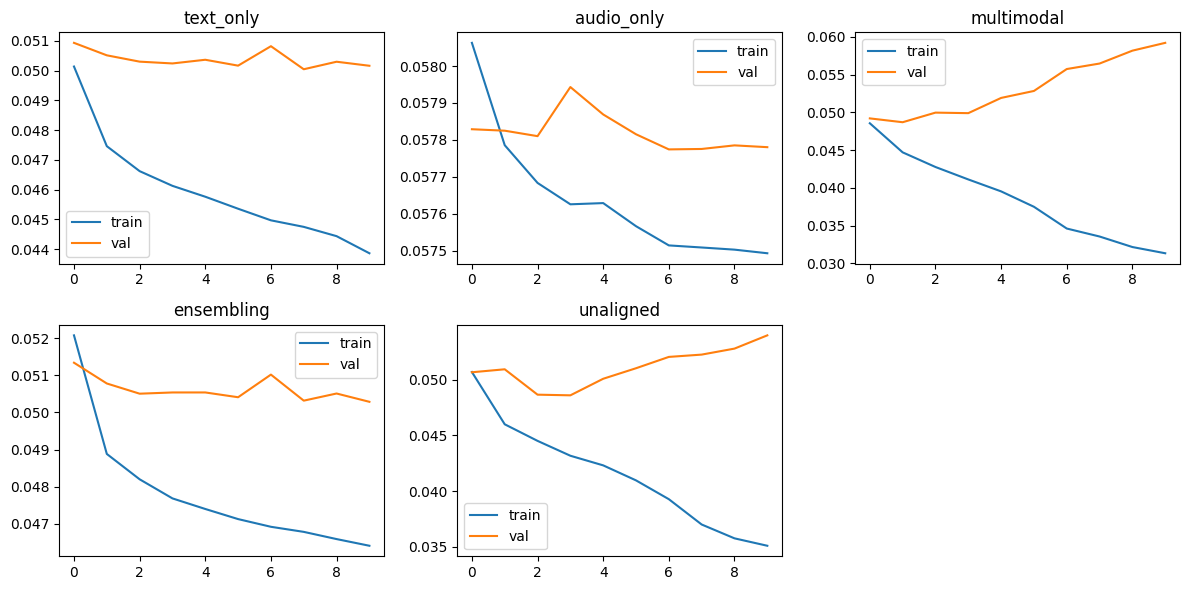

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, model_name in enumerate(train_losses.keys()):
    tr_losses_model = np.mean(train_losses[model_name], axis=0)
    vl_losses_model = np.mean(val_losses[model_name], axis=0)
    axes[i//3, i%3].plot(tr_losses_model, label='train')
    axes[i//3, i%3].plot(vl_losses_model, label='val')
    axes[i//3, i%3].set_title(model_name)
    axes[i//3, i%3].legend()
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

Best results store for each model the results obtained in the seed which produced the highest F1 score

In [24]:
# taking the best results for each model based on the highest F1-score obtained in a seed
best_results = {
    model_name: max(test_results[model_name], key=lambda x: x['f1']) for model_name in test_results.keys()
}

## Mean and Standard Deviation for Accuracy, F1, AUC

In [25]:
# mean and standard deviation for the accuracy, F1 and AUC
aggregated_results = {}
for model_name, results in test_results.items():
    aggregated_results[model_name] = {
        'acc mean': torch.tensor([x['acc'] for x in results]).mean().item(),
        'acc std': torch.tensor([x['acc'] for x in results]).std().item(),
        'f1 mean': torch.tensor([x['f1'] for x in results]).mean().item(),
        'f1 std': torch.tensor([x['f1'] for x in results]).std().item(),
        'AUC mean': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).mean().item(),
        'AUC std': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).std().item(),
    }

# create multiindex dataframe with first level accuracy, f1 and second level mean and std
aggregated_results_df = pd.DataFrame(aggregated_results).T
aggregated_results_df.columns = pd.MultiIndex.from_product([['Accuracy', 'F1', 'AUC'], ['mean', 'std']])
aggregated_results_df.sort_values(by=('F1', 'mean'), ascending=False)

Accuracy          F1         AUC      
               mean   std  mean   std  mean   std
unaligned     0.697 0.002 0.696 0.003 0.697 0.003
multimodal    0.693 0.003 0.691 0.003 0.692 0.003
ensembling    0.682 0.002 0.682 0.002 0.682 0.002
text_only     0.681 0.002 0.679 0.003 0.680 0.003
audio_only    0.546 0.003 0.527 0.014 0.542 0.002

## ROC curves and AUC for the model in best_results

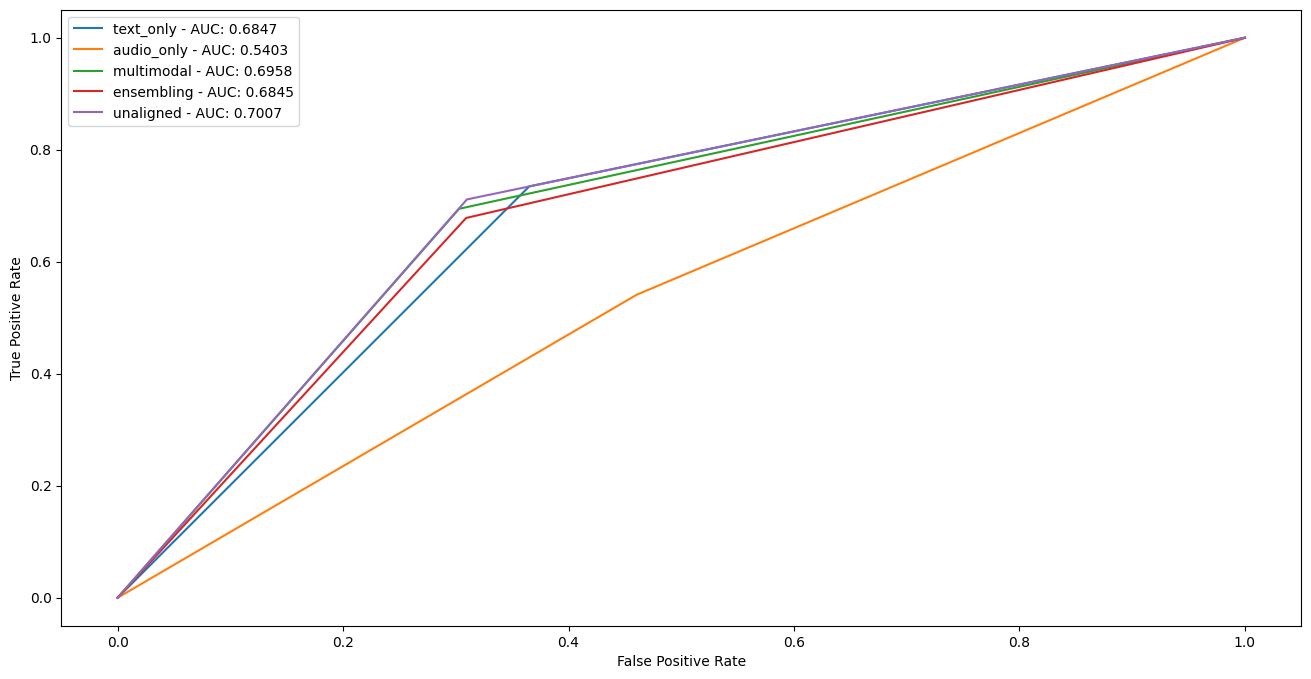

In [26]:
# plot ROC curves and compute AUC
plt.figure(figsize=(16, 8))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the ROC curve
    fpr, tpr, _ = roc_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # compute the AUC
    auc = roc_auc_score(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} - AUC: {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall curves for models in best_models

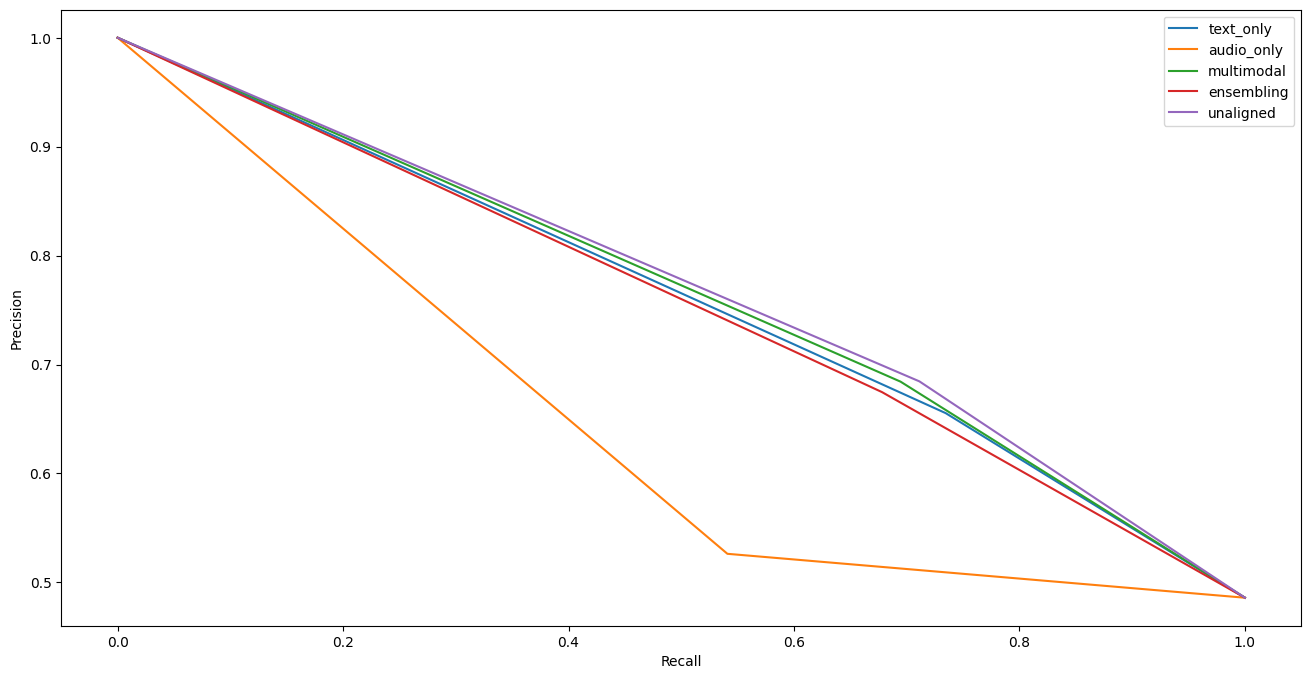

In [27]:
# plot precision-recall curves
plt.figure(figsize=(16, 8))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the precision-recall curve
    precision, recall, _ = precision_recall_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the precision-recall curve
    plt.plot(recall, precision, label=f'{model_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Confusion Matrix for models in best_models

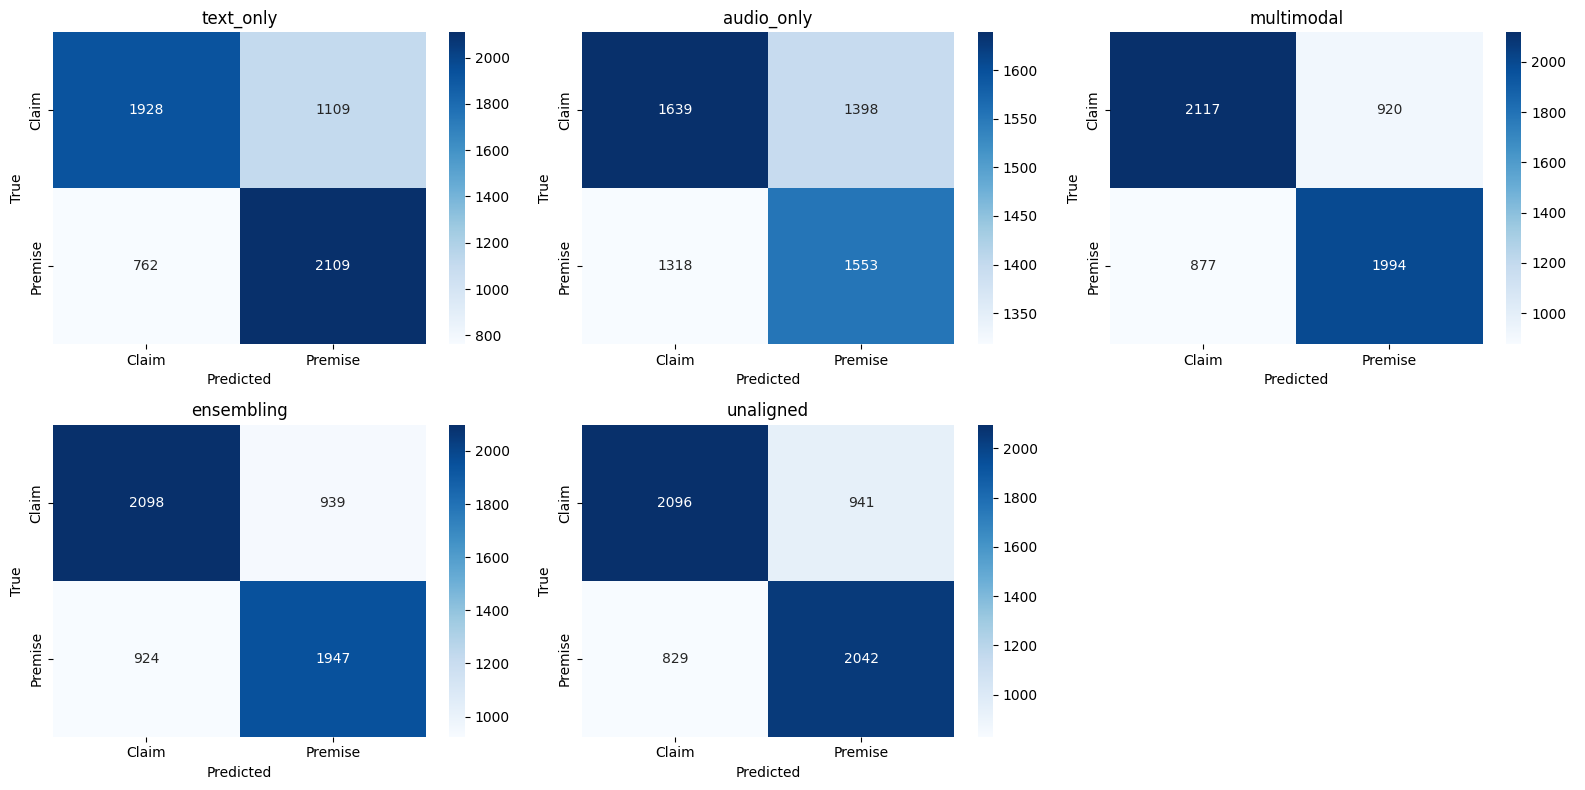

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, model_name in enumerate(test_results.keys()):
    best_result = best_results[model_name]
    
    cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_result['targ'].cpu()],
                      [ID_2_LABEL[label.item()] for label in best_result['pred'].cpu()])
                      
    sns.heatmap(cm, annot=True, ax=axes[i//3][i%3], fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
    axes[i//3][i%3].set_title(model_name)
    axes[i//3][i%3].set_xlabel('Predicted')
    axes[i//3][i%3].set_ylabel('True')
axes[1][2].axis('off')
plt.tight_layout()
plt.show()

# Breakdown analysis on the Best performing model

Best performing model: unaligned
Accuracy: 0.7004
F1: 0.7004
AUC: 0.7007

              precision    recall  f1-score   support

       Claim       0.72      0.69      0.70      3037
     Premise       0.68      0.71      0.70      2871

    accuracy                           0.70      5908
   macro avg       0.70      0.70      0.70      5908
weighted avg       0.70      0.70      0.70      5908



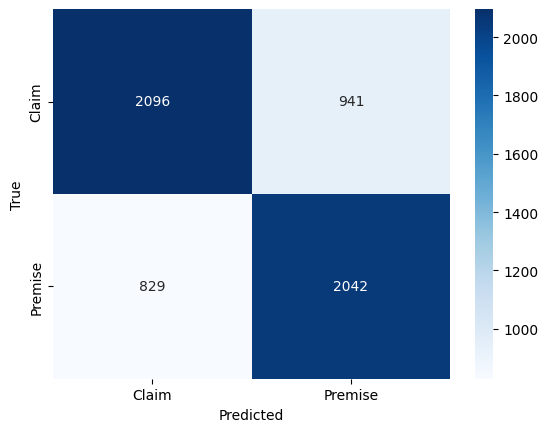

In [29]:
best_performing_model_name = max(aggregated_results_df['F1']['mean'].items(), key=lambda x: x[1])[0]

best_performing_model = max(test_results[best_performing_model_name], key=lambda x: x['f1'])

print(f'Best performing model: {best_performing_model_name}')
print(f'Accuracy: {best_performing_model["acc"]:.4f}')
print(f'F1: {best_performing_model["f1"]:.4f}')
print(f'AUC: {roc_auc_score(best_performing_model["targ"].cpu(), best_performing_model["pred"].cpu()):.4f}')
print()

print(classification_report([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                            [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])) 

cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                        [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])          

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()